In [201]:
import numpy as np
from scipy.optimize import bisect
import pandas as pd 
from matplotlib import pyplot as plt
from scipy.stats import norm

# Identification

The model is
$$
\max_{m_i} \frac{(y_i-pm_i)^{1-\sigma}}{1-\sigma} + \phi (1-\exp(-\alpha_1 - \alpha_0 \log m_i))
$$
The FOC is 
$$
p (y_i-pm_i)^{-\sigma} = \phi\frac{\alpha_0}{m_i} \exp(-\alpha_1 - \alpha_0 \log m_i)
$$
This gives a solution $m_i = {\cal M}(y_i,p|\sigma, \phi, \alpha_0, \alpha1)$


### US
For the US, we have $p=1$ and $\sum_i \omega_i y_i \equiv y = 1$. Therefore, the moments restrictions  
$$
\Psi_1 = \frac{p \sum_i \omega_i m_i}{\sum_i \omega_i y_i}
$$
$$
\Psi_2 = \sum_i (1-\exp(-\alpha_1 - \alpha_0 \log m_i))
$$
$$
\Psi_3 = \frac{(1-\exp(-\alpha_1 - \alpha_0 \log m_{\max}))}{(1-\exp(-\alpha_1 - \alpha_0 \log m_{\min}))}
$$
allows to identify $\{\phi,\alpha_0,\alpha_1\}$


### Europe

For Europe, we keep $\{\phi,\alpha_0,\alpha_1\}$ found in the previous step, and the moments restrictions
$$
\Psi_1 = \frac{p \sum_i \omega_i m_i}{\sum_i \omega_i y_i}
$$
$$
\Psi_2 = \sum_i (1-\exp(-\alpha_1 - \alpha_0 \log m_i))
$$
allows to identify $\{p,\alpha_1\}$, given that a calibration of $\sum_i \omega_i y_i \equiv y$



We start by programming functions for finding optimal $m$ from the first-order condition:

In [202]:
def foc(m,sigma_c,phi,alphas,y,p):
	return p*(y-p*m)**(-sigma_c) - (alphas[0]/(0.001+m))*phi*np.exp(-alphas[1]-alphas[0]*np.log(0.001 + m))
def u(m,sigma_c,phi,alphas,y,p):
	return ((y-p*m)**(1-sigma_c))/(1-sigma_c) + phi*(1-np.exp(-alphas[1] - alphas[0]*np.log(0.001+m)))
def optm(sigma_c,phi,alphas,y,p):
	try:
		m = bisect(foc,0.01,y*0.99,args=(sigma_c,phi,alphas,y,p))
	except:
		up = u(0.99*y,sigma_c,phi,alphas,y,p)
		low = u(0.0,sigma_c,phi,alphas,y,p)
		if up>low:
			m = 0.99*y
		else :
			m = 0.0
	return m

These are the parameters that we end up getting, but we check here that the function works. 

In [203]:
alphas_us = [0.5,0.25]
sigma_c = 2
phi = 2.95

We start with income and price normalized in U.S. 

In [204]:
p_us = 1

We load up the parameters of the income process and use that to compute 4 median incomes within quartiles. The stationary variance of the income process of each country is 

In [205]:
sigs = pd.read_pickle('../model/params/income_shocks.pkl')
sigs = sigs.loc['sige',:]/(1-sigs.loc['rho',:]**2)
sigs

DE    0.256367
DK    0.094643
FR    0.214538
IT    0.237439
NL    0.169834
SE    0.094643
SP    0.270357
US    0.486429
dtype: float64

For Europe, we take a mean. 

In [206]:
sig_us = sigs['US']
sig_eu = sigs[:'SP'].mean()
sig_us,sig_eu

(0.4864286549343358, 0.1911170778053603)

We program up the income distribution, making sure it has a mean of 1. 

In [207]:
qs = [0.125,0.375,0.625,0.875]
yy_us = [norm(0,np.sqrt(sig_us)).ppf(q) for q in qs]
yy_us = np.exp(yy_us)
yy_us = yy_us/np.mean(yy_us)
yy_us,np.mean(yy_us)

(array([0.37922278, 0.67735486, 1.05644182, 1.88698055]), 1.0)

We can check that the function returns s in the U.S. 

In [208]:
np.mean([optm(sigma_c,phi,alphas_us,y_us,p_us) for y_us in yy_us])

0.48089616235236954

We use the following moments for the U.S. 

In [209]:
s_us = 0.15
h_us = 0.89
grad_us = 1.27

We do the same for Europe but scale down everything to have an average income of 0.78

In [210]:
y_eu = 0.78
qs = [0.125,0.375,0.625,0.875]
yy_eu = [norm(0,np.sqrt(sig_eu)).ppf(q) for q in qs]
yy_eu = np.exp(yy_eu)
yy_eu = yy_eu/np.mean(yy_eu)
yy_eu = y_eu*yy_eu
yy_eu,np.mean(yy_eu)

(array([0.44109987, 0.63452042, 0.83837729, 1.20600242]), 0.78)

For Europe we can check that things work out. 

In [211]:
alphas_eu = [7.2,1.87]
p_eu = 0.54


In [212]:
p_eu*np.mean([optm(sigma_c,phi,alphas_eu,y_eu,p_eu) for y_eu in yy_eu])/np.mean(yy_eu)

0.518924442017017

We use the following moments for Europe (we do not use the gradient but still compare):

In [213]:
s_eu = 0.096
h_eu = 0.93
grad_eu = 1.06

In [214]:
def prod(alphas,m):
	return 1 - np.exp(-alphas[1] - alphas[0]*np.log(0.001+m))
def hopt(sigma_c,phi,alphas,y,p):
	m = optm(sigma_c,phi,alphas,y,p)
	return prod(alphas,m)

# Calibration

We start the exercise with finding U.S. parameters that fit the moments. We are solving a set of equations for three unknowns, $\alpha_0$, $\alpha_{1,US}$ and $\phi$. We use the methods of moments to minimize the squared distance of moments. 

In [215]:
def criterion_us(theta,sigma_c,alphas,y,p,moms):
	alphas[0] = theta[0]
	alphas[1] = theta[1]
	phi = theta[2]
	ms = [optm(sigma_c,phi,alphas,i,p) for i in y]
	moms_s = np.zeros(3)
	moms_s[0] = p*np.sum(ms)/np.sum(y)
	moms_s[1] = np.mean([prod(alphas,m) for m in ms])
	moms_s[2] = prod(alphas,ms[3])/prod(alphas,ms[0])
	return (moms[0] - moms_s[0])**2 + (moms[1] - moms_s[1])**2 + (moms[2] - moms_s[2])**2

These are the estimates reported in the text:

In [216]:
from scipy.optimize import minimize

opt_us = minimize(criterion_us,[0.5,1.5,2.0],args=(sigma_c,[0.0,0.0],yy_us,p_us,[s_us,h_us,grad_us]))
alphas_us[0] = opt_us.x[0]
alphas_us[1] = opt_us.x[1]
phi = opt_us.x[2]
alphas_us,phi

([1.636163869461565, 5.745322881406936], 1.9679994658718702)

We can check that we match moments

In [217]:
ms = [optm(sigma_c,phi,alphas_us,i,p_us) for i in yy_us]
np.mean(ms)

0.150001867987312

In [218]:
ms

[0.07114317808170459,
 0.11316826834446443,
 0.16107621840076664,
 0.2546198071223123]

In [219]:
h = np.mean([prod(alphas_us,m) for m in ms])
h

0.889993201234464

In [220]:
prod(alphas_us,ms[3])/prod(alphas_us,ms[0])

1.270000208164957

In [221]:
hs = [prod(alphas_us,m) for m in ms]

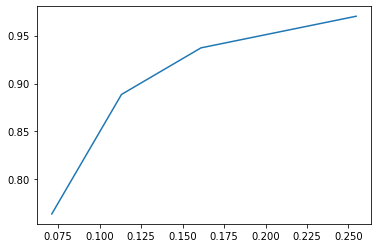

In [222]:
ms_us = ms[:]
hs_us = hs[:]
plt.figure()
plt.plot(ms_us,hs_us)
plt.show()

In Europe, we seek to estimate $p_{EU}$ and $\alpha_{1,EU}$ using $(s_{EU},h_{EU})$ as moments

In [223]:
def criterion_eu(theta,sigma_c,phi,alphas,y,moms):
	alphas[1] = theta[0]
	p = theta[1]
	ms = [optm(sigma_c,phi,alphas,i,p) for i in y]
	moms_s = np.zeros(2)
	moms_s[0] = p*np.mean(ms)/np.mean(y)
	moms_s[1] = np.mean([prod(alphas,m) for m in ms])
	return (moms[0] - moms_s[0])**2 + (moms[1] - moms_s[1])**2

These are the estimates reported in the paper:

In [224]:
alphas_eu[0] = alphas_us[0]
opt_eu = minimize(criterion_eu,[6.0,0.8],args=(sigma_c,phi,alphas_eu,yy_eu,[s_eu,h_eu]))
alphas_eu[1] = opt_eu.x[0]
p_eu = opt_eu.x[1]
alphas_eu[1],p_eu

(6.11935403975547, 0.5550287285460922)

We can check that we fit the targeted moments:

In [225]:
ms = [optm(sigma_c,phi,alphas_eu,i,p_eu) for i in yy_eu]
p_eu*np.mean(ms)/np.mean(yy_eu)

0.10184780493628416

In [226]:
h = np.mean([prod(alphas_eu,m) for m in ms])
h

0.9376746282257125

The gradient is lower than in the U.S. but slighly larger than the target (1.06)

In [227]:
prod(alphas_eu,ms[3])/prod(alphas_eu,ms[0])

1.085749409167824